<H1> Ingénierie des données textuelles </H1>  

De nombreuses applications utilisent des données textuelles pour faire de la prédiction : détection d'opinions, classification automatique de documents en fonction du contenu : spam - no spam, article sport vs article économie, etc...   

La classification se fait de manière tout à fait classique par contre il est indispensable de traiter les documents pour pouvoir les faire interpréter par un classifieur.
Le traitement des données textuelles est particulièrement difficile car il dépend des données disponibles et tout traitement n'est pas forcément justifié. Par exemple le fait de convertir tout le texte en minuscule peut faire perdre de l'information (*e.g., Mr Play indique une personne et play un verbe*), la suppression des ponctuations peut avoir des conséquences (*! est très souvent utilisé pour la détection d'opinions*), etc. En outre chaque langue possède aussi ses particularités et les librairies disponibles considèrent souvent l'anglais même s'il existe de plus en plus de ressources en différentes langues comme le français.  

Le but de ce notebook est de présenter différentes approches d'ingénierie de données textuelles afin de pré-traiter les données.   

Comme nous le verrons tout au cours de ce notebook, il existe de nombreuses librairies qui offrent des fonctionnalités pour pouvoir facilement traiter les données. 


## Installation



Avant de commencer, il est nécessaire de déjà posséder dans son environnement toutes les librairies utiles. Dans la seconde cellule nous importons toutes les librairies qui seront utiles à ce notebook. Il se peut que, lorsque vous lanciez l'éxecution de cette cellule, une soit absente. Dans ce cas il est nécessaire de l'installer. Pour cela dans la cellule suivante utiliser la commande :  

*! pip install nom_librairie*  

**Attention :** il est fortement conseillé lorsque l'une des librairies doit être installer de relancer le kernel de votre notebook.

**Remarque :** même si toutes les librairies sont importées dès le début, les librairies utiles pour des fonctions présentées au cours de ce notebook sont ré-importées de manière à indiquer d'où elles viennent et ainsi faciliter la réutilisation de la fonction dans un autre projet.


In [45]:
# utiliser cette cellule pour installer les librairies manquantes
# pour cela il suffit de taper dans cette cellule : !pip install nom_librairie_manquante
# d'exécuter la cellule et de relancer la cellule suivante pour voir si tout se passe bien
# recommencer tant que toutes les librairies ne sont pas installées ...

# sous Colab il faut déjà intégrer ces deux librairies

! pip install langdetect 
!pip install contractions

! pip install wordcloud
# eventuellement ne pas oublier de relancer le kernel du notebook

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
# Importation des différentes librairies utiles pour le notebook

#Sickit learn met régulièrement à jour des versions et 
#indique des futurs warnings. 
#ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# librairies générales
import pickle 
import pandas as pd
from scipy.stats import randint
import numpy as np
import string
import time
import base64
import re
import sys

import contractions

# librairie BeautifulSoup
from bs4 import BeautifulSoup

# librairie affichage
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud

## detection de language
import langdetect 

import nltk
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from nltk import RegexpParser
# il est possible de charger l'ensemble des librairies en une seule fois 
# décocher le commentaire de la ligne ci-dessous
#nltk.download('all') 
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag
nltk.download('tagsets')
nltk.download("stopwords")
nltk.download('wordnet')

from nltk.corpus import stopwords

import spacy
from spacy.tokens import Span
# il faut sélectionner pour quelle langue les traitements vont être faits.

# !python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")
from spacy.lang.fr import French

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Pour pouvoir sauvegarder sur votre répertoire Google Drive, il est nécessaire de fournir une autorisation. Pour cela il suffit d'éxecuter la ligne suivante et de saisir le code donné par Google.

In [47]:
# pour monter son drive Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Corriger éventuellement la ligne ci-dessous pour mettre le chemin vers un répertoire spécifique dans votre répertoire Google Drive : 

In [48]:
my_local_drive='/content/gdrive/My Drive/Colab Notebooks/ML_FDS'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd

/content/gdrive/My Drive/Colab Notebooks/ML_FDS


'/content/gdrive/My Drive/Colab Notebooks/ML_FDS'

In [49]:
# fonctions utilities (affichage, confusion, etc.)
from MyNLPUtilities import *

## **Une première analyse des documents**

Très souvent pour commencer à appréhender un texte, l'une des approches consiste à déjà regarder les mots principaux d'un texte. Les word clouds offrent cette fonctionnalité. Il est également utile de connaître la langue du document. Par exemple, cela va permettre de pouvoir utiliser des librairies spécifiques, supprimer des mots inutiles pour cette langue, etc.  

Il existe heureusement des librairies spécifiques comme *wordcloud* ou *langdetect*.  

Nous présentons par la suite quelques premiers petits traitements pratiques qui peuvent être effectués pour nettoyer un peu les données.

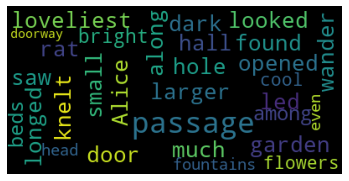

 Le document ' Alice opened the door and found that it led into a small passage, not much larger than a rat-hole: she knelt down and looked along the passage into the loveliest garden you ever saw. How she longed to get out of that dark hall, and wander about among those beds of bright flowers and those cool fountains, but she could not even get her head through the doorway ' est en   en
la phrase il fait beau est en  fr


In [50]:
import wordcloud

## detection de language
import langdetect 
document = "Alice opened the door and found that it led into a small passage, not much larger than a rat-hole: she knelt down and looked along the passage into the loveliest garden you ever saw. \
How she longed to get out of that dark hall, and wander about among those beds of bright flowers and those cool fountains, but she could not even get her head through the doorway"

# affichage des word clouds
wc = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=35)
wc = wc.generate(str(document))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.show()


print(" Le document '", document, "' est en  ", langdetect.detect(document))
print ("la phrase il fait beau est en ", langdetect.detect("il fait beau"))

**Encodage des données**  
Les données textuelles sont souvent sujettes à des problèmes d'encodage ( “Latin”, “UTF8” etc). Le plus simple est de les convertir dans un format classique (UTF8).

In [51]:
import unicodedata
chaine = u"Klüft skräms inför på fédéral électoral große"
chaine=unicodedata.normalize('NFKD', chaine).encode('ascii','ignore')
print (chaine)

b'Kluft skrams infor pa federal electoral groe'


**Suppression des tags XML/HTML**  
Les données textuelles peuvent être issues de pages web, contenir des entêtes, etc..
L'une des premières étapes consistent à les nettoyer pour ne retenir que le texte.
La librairie BeautifulSoup permet de récupérer directement le texte en supprimant les tags : https://www.crummy.com/software/BeautifulSoup/bs4/doc/

In [52]:
page = """
<!DOCTYPE html>
<html> <head> <title>Machine Learning - Apprentissage</title> </head>
  <body>
 
<h1>Le cours de Machine Learning est à a FDS </h1> (<a href=https://sciences.edu.umontpellier.fr>).

 Situé à Montpellier [où il fait toujours beau]
</body> </html>"""
print (page)


<!DOCTYPE html>
<html> <head> <title>Machine Learning - Apprentissage</title> </head>
  <body>
 
<h1>Le cours de Machine Learning est à a FDS </h1> (<a href=https://sciences.edu.umontpellier.fr>).

 Situé à Montpellier [où il fait toujours beau]
</body> </html>


In [53]:
from bs4 import BeautifulSoup

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

page=strip_html (page)
print (page)



  Machine Learning - Apprentissage 

Le cours de Machine Learning est à a FDS  ().

 Situé à Montpellier [où il fait toujours beau]
 


**Utilisation d'expressions régulières**  

De nombreuses modifications peuvent être réalisées en utilisant des expressions régulières (utilisation de la librairie *re*). Par exemple la fonction suivante permet de supprimer les textes entre crochets [].  

Nous verrons d'autres exemples d'expressions régulières par la suite. 


In [54]:
import re
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

page=remove_between_square_brackets(page)
print (page)



  Machine Learning - Apprentissage 

Le cours de Machine Learning est à a FDS  ().

 Situé à Montpellier 
 


## **Plus loin dans les pré-traitements des documents**

La phase de pré-traitement est la phrase de préparation des données pour que ces dernières soient utilisables par un modèle d'apprentissage. Outre l'étape de nettoyage des données,  il y a de nombreux pré-traitements qui peuvent ou doivent être effectués en fonction de leur type et de la tâche visée. Par exemple, l'extraction des tokens composant les phrases, la racinisation/"stemmatisation" qui vise à garder la racine des mots, la lemmatisation qui consiste à appliquer une analyse lexicale d'un texte, la suppression de mots vides ou creux (i.e., des mots qui ne sont pas discriminants pour la classification), la détection d'entité nommée, etc.   

 

L'étape de nettoyage peut contenir elle même différentes sous-étapes selon les données (Cf. exemple précédent avec des données HTML) et la tâche visée. Elle comprend souvent la conversion des documents en minuscule et la suppression des signes de ponctuations.   

Comme nous l'avons vu précédemment, il existe de nombreuses librairies pour effectuer ces différentes tâches. Dans ce notebook nous nous intéresserons plus particulièrement à 
 :
* la librairie NLTK (Natural Language Toolkit) : http://www.nltk.org
* la librairie SpaCY : https://spacy.io/  

Nous présentons comment ces dernières peuvent être utilisées pour réaliser les différents pré-traitements. 
L'importation de ces librairie se fait de la manière suivante :
  

In [55]:
import nltk
# il est possible de charger l'ensemble des librairies en une seule fois 
# décocher le commentaire de la ligne ci-dessous
#nltk.download('all') 

import spacy
# il faut sélectionner pour quelle langue les traitements vont être faits.


In [56]:
import nltk
# il est possible de charger l'ensemble des librairies en une seule fois 
# décocher le commentaire de la ligne ci-dessous
#nltk.download('all') 

import spacy
# il faut sélectionner pour quelle langue les traitements vont être faits.
nlp = spacy.load("en_core_web_sm")

# Utilisation de NLTK

NLTK (Natural Language Toolkit - http://www.nltk.org) est une bibliothèque Python développée par Steven Bird et Edward Loper du département d'informatique de l'université de Pennsylvanie. Elle offre de très nombreuses fonctionnalités pour manipuler les textes dans différentes langues dont le français.  

L'importation de la librairie se fait par : 

In [57]:
import nltk
# il est possible de charger l'ensemble des librairies associées en une seule fois 
# pour cela décocher le commentaire de la ligne ci-dessous
#nltk.download('all') 

In [58]:
document = "Alice opened the door and found that it led into a small passage, not much larger than a rat-hole: she knelt down and looked along the passage into the loveliest garden you ever saw. \
How she longed to get out of that dark hall, and wander about among those beds of bright flowers and those cool fountains, but she could not even get her head through the doorway"

Sous NLTK,  le découpage en phrase peut se faire  à l'aide de la fonction *sent_tokenize* :

In [59]:
import nltk
nltk.download('punkt')
from nltk import sent_tokenize

phrases = sent_tokenize(document)
for phrase_nltk in phrases:
  print ("phrases : ",phrase_nltk)

phrases :  Alice opened the door and found that it led into a small passage, not much larger than a rat-hole: she knelt down and looked along the passage into the loveliest garden you ever saw.
phrases :  How she longed to get out of that dark hall, and wander about among those beds of bright flowers and those cool fountains, but she could not even get her head through the doorway


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Découpage en tokens (tokenisation)**  

Un texte sous python est généralement considéré comme *string*. Il est donc tout à fait possible  d'utiliser les fonctions associées comme *lower* (conversion en minuscule) ou la fonction *split* associée pour découper en tokens. 

In [60]:
print ("conversion document en minuscule")
print (document.lower())

document_splitted = document.split()
print(document_splitted)

conversion document en minuscule
alice opened the door and found that it led into a small passage, not much larger than a rat-hole: she knelt down and looked along the passage into the loveliest garden you ever saw. how she longed to get out of that dark hall, and wander about among those beds of bright flowers and those cool fountains, but she could not even get her head through the doorway
['Alice', 'opened', 'the', 'door', 'and', 'found', 'that', 'it', 'led', 'into', 'a', 'small', 'passage,', 'not', 'much', 'larger', 'than', 'a', 'rat-hole:', 'she', 'knelt', 'down', 'and', 'looked', 'along', 'the', 'passage', 'into', 'the', 'loveliest', 'garden', 'you', 'ever', 'saw.', 'How', 'she', 'longed', 'to', 'get', 'out', 'of', 'that', 'dark', 'hall,', 'and', 'wander', 'about', 'among', 'those', 'beds', 'of', 'bright', 'flowers', 'and', 'those', 'cool', 'fountains,', 'but', 'she', 'could', 'not', 'even', 'get', 'her', 'head', 'through', 'the', 'doorway']



Via NLTK, le découpage en tokens se fait via la fonction *word_tokenize*. Contrairement à la fonction *split* précédente, les caractères de ponctuations sont considérés comme tokens.   

**Remarque :** comme nous pouvons le constater les ponctuations sont soient intégrées au dernier mot (*split*), soient correspondent à des tokens. Nous verrons jusque après que NTLK peut les reconnaître spécifiquement via une analyse grammaticale. 


In [61]:
from nltk.tokenize import word_tokenize
# la liste des tokens de la première phrase
tokens = word_tokenize(phrases[0])
print(tokens)

['Alice', 'opened', 'the', 'door', 'and', 'found', 'that', 'it', 'led', 'into', 'a', 'small', 'passage', ',', 'not', 'much', 'larger', 'than', 'a', 'rat-hole', ':', 'she', 'knelt', 'down', 'and', 'looked', 'along', 'the', 'passage', 'into', 'the', 'loveliest', 'garden', 'you', 'ever', 'saw', '.']


**Etiquetage grammatical** (*Part of Speech Tagging*)  

L'étiquetage morpho-syntaxique (ou étiquetage grammatical) permet d'associer à chaque mot d'un texte les informations grammaticales correpondantes (e.g. verbe, préposition, ...).  
Elle se fait via la fonction *pos_tag*. Elle s'applique à une phrase composée d'un ensemble de tokens et retourne les différents composants de la phrase. 



In [62]:
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')

for phrase_nltk in phrases:
  print ("phrases : ",phrase_nltk)
  tokens = word_tokenize(phrase_nltk)
  tokens_tag = nltk.pos_tag(tokens)
  print (tokens_tag)

phrases :  Alice opened the door and found that it led into a small passage, not much larger than a rat-hole: she knelt down and looked along the passage into the loveliest garden you ever saw.
[('Alice', 'NNP'), ('opened', 'VBD'), ('the', 'DT'), ('door', 'NN'), ('and', 'CC'), ('found', 'VBD'), ('that', 'IN'), ('it', 'PRP'), ('led', 'VBD'), ('into', 'IN'), ('a', 'DT'), ('small', 'JJ'), ('passage', 'NN'), (',', ','), ('not', 'RB'), ('much', 'RB'), ('larger', 'JJR'), ('than', 'IN'), ('a', 'DT'), ('rat-hole', 'JJ'), (':', ':'), ('she', 'PRP'), ('knelt', 'VBD'), ('down', 'RB'), ('and', 'CC'), ('looked', 'VBD'), ('along', 'IN'), ('the', 'DT'), ('passage', 'NN'), ('into', 'IN'), ('the', 'DT'), ('loveliest', 'JJS'), ('garden', 'NN'), ('you', 'PRP'), ('ever', 'RB'), ('saw', 'VBD'), ('.', '.')]
phrases :  How she longed to get out of that dark hall, and wander about among those beds of bright flowers and those cool fountains, but she could not even get her head through the doorway
[('How', 'WRB

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Il est possible de connaître la liste de tous les tags disponibles :

In [63]:
nltk.download('tagsets')
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


A partir de cet étiquetage, il est donc possible de ne sélectionner que des tokens correspondant à une catégorie. 

In [64]:
word_tokens = word_tokenize(document)
pos = nltk.pos_tag(word_tokens)
selective_pos = ['NN','VBD']
selective_pos_words = []
for word,tag in pos:
     if tag in selective_pos:
         selective_pos_words.append((word,tag))
print(selective_pos_words)

[('opened', 'VBD'), ('door', 'NN'), ('found', 'VBD'), ('led', 'VBD'), ('passage', 'NN'), ('knelt', 'VBD'), ('looked', 'VBD'), ('passage', 'NN'), ('garden', 'NN'), ('saw', 'VBD'), ('longed', 'VBD'), ('dark', 'NN'), ('hall', 'NN'), ('head', 'NN'), ('doorway', 'NN')]


**Mots vides** *Stop words*  

Les mots vides correspondent à des mots qui sont tellement commun qu'il n'est pas nécessaire de les considérer dans l'apprentissage. NLTK possède une liste prédéfinie de mots vides faisant référence aux mots les plus courants. La première fois, il est nécessaire de télécharger les mots vides en utilisant : *nltk.download («stopwords»)*. 

In [65]:
nltk.download("stopwords")
from nltk.corpus import stopwords
the_stopwords=set(stopwords.words("english"))
print (the_stopwords)

{'out', 'who', 'had', 'couldn', 'ourselves', 'd', 'our', 'his', 'mustn', 'll', "wasn't", "don't", "hadn't", 'very', 'up', 'herself', 'm', 'same', 'through', 'if', 'does', 'against', 'theirs', 'i', 'yours', 'haven', 'yourselves', 'be', 'between', "couldn't", "doesn't", 'what', 'few', 'doing', 'other', 'and', 'should', 'before', 'with', 'can', 'their', 'we', 'myself', 'having', 'too', 'themselves', 'the', 'aren', 'because', 'is', 'weren', 'wouldn', "should've", 'been', 'of', "she's", 'above', "you've", 'more', 'than', 'for', 'didn', 'not', 'was', 'while', 'down', 'now', 'won', 'most', 'were', 'once', "won't", 'such', 'don', 'am', 'she', 'whom', 'under', "wouldn't", 'doesn', 'this', 'just', 'off', "you'll", 'an', 'own', 'those', 've', "hasn't", 'these', 'any', "mightn't", 'about', "isn't", 'a', 'in', 'as', 'hadn', 'hers', 'do', "shan't", "shouldn't", 'him', 'he', 'where', 'ours', 'then', 'at', 'some', 'my', 'that', 'have', "mustn't", "you're", 'each', 'shouldn', 'being', 'shan', 'them', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Il est tout à fait possible de supprimer des stopwords de cette liste : 

In [66]:
not_stopwords = {'this', 'd', 'o'} 
#new_stopwords_list=stopwords
final_stop_words = set([word for word in the_stopwords if word not in not_stopwords])

print (final_stop_words)

{'out', 'who', 'had', 'couldn', 'ourselves', 'our', 'his', 'mustn', 'll', "wasn't", "don't", "hadn't", 'very', 'up', 'herself', 'm', 'same', 'through', 'if', 'does', 'against', 'theirs', 'i', 'yours', 'haven', 'yourselves', 'be', 'between', "couldn't", "doesn't", 'what', 'few', 'doing', 'other', 'and', 'should', 'before', 'with', 'can', 'their', 'we', 'myself', 'having', 'too', 'themselves', 'the', 'aren', 'because', 'is', 'weren', 'wouldn', "should've", 'been', 'of', "she's", 'above', "you've", 'more', 'than', 'for', 'didn', 'not', 'was', 'while', 'down', 'now', 'won', 'most', 'were', 'once', "won't", 'such', 'don', 'am', 'she', 'whom', 'under', "wouldn't", 'doesn', 'just', 'off', "you'll", 'an', 'own', 'those', 've', "hasn't", 'these', 'any', "mightn't", 'about', "isn't", 'a', 'in', 'as', 'hadn', 'hers', 'do', "shan't", "shouldn't", 'him', 'he', 'where', 'ours', 'then', 'at', 'some', 'my', 'that', 'have', "mustn't", "you're", 'each', 'shouldn', 'being', 'shan', 'them', 'into', 'me', 

ou d'étendre la liste des stop words.

In [67]:
new_stopwords=['stopword1', 'stopword2']
final_stop_words=final_stop_words.union(new_stopwords)

print (final_stop_words)

{'out', 'who', 'had', 'couldn', 'ourselves', 'our', 'his', 'mustn', 'll', "wasn't", "don't", "hadn't", 'very', 'up', 'herself', 'm', 'same', 'stopword1', 'through', 'if', 'does', 'against', 'theirs', 'i', 'yours', 'haven', 'yourselves', 'be', 'between', "couldn't", "doesn't", 'what', 'few', 'doing', 'other', 'and', 'should', 'before', 'with', 'can', 'their', 'we', 'myself', 'having', 'too', 'themselves', 'the', 'aren', 'because', 'is', 'weren', 'wouldn', "should've", 'been', 'of', "she's", 'above', "you've", 'more', 'than', 'for', 'didn', 'not', 'was', 'while', 'down', 'now', 'won', 'most', 'were', 'stopword2', 'once', "won't", 'such', 'don', 'am', 'she', 'whom', 'under', "wouldn't", 'doesn', 'just', 'off', "you'll", 'an', 'own', 'those', 've', "hasn't", 'these', 'any', "mightn't", 'about', "isn't", 'a', 'in', 'as', 'hadn', 'hers', 'do', "shan't", "shouldn't", 'him', 'he', 'where', 'ours', 'then', 'at', 'some', 'my', 'that', 'have', "mustn't", "you're", 'each', 'shouldn', 'being', 'sha

Pour supprimer les stopwords d'un document, il suffit de rechercher les tokens qui sont inclus dans les stopwords et de les supprimer. 

In [68]:
print ("Avant suppression des stopwords")
print (word_tokens)
tokens_Alice=[word for word in word_tokens if word not in the_stopwords]
print ("Après suppression des stopwords")
print (tokens_Alice)

Avant suppression des stopwords
['Alice', 'opened', 'the', 'door', 'and', 'found', 'that', 'it', 'led', 'into', 'a', 'small', 'passage', ',', 'not', 'much', 'larger', 'than', 'a', 'rat-hole', ':', 'she', 'knelt', 'down', 'and', 'looked', 'along', 'the', 'passage', 'into', 'the', 'loveliest', 'garden', 'you', 'ever', 'saw', '.', 'How', 'she', 'longed', 'to', 'get', 'out', 'of', 'that', 'dark', 'hall', ',', 'and', 'wander', 'about', 'among', 'those', 'beds', 'of', 'bright', 'flowers', 'and', 'those', 'cool', 'fountains', ',', 'but', 'she', 'could', 'not', 'even', 'get', 'her', 'head', 'through', 'the', 'doorway']
Après suppression des stopwords
['Alice', 'opened', 'door', 'found', 'led', 'small', 'passage', ',', 'much', 'larger', 'rat-hole', ':', 'knelt', 'looked', 'along', 'passage', 'loveliest', 'garden', 'ever', 'saw', '.', 'How', 'longed', 'get', 'dark', 'hall', ',', 'wander', 'among', 'beds', 'bright', 'flowers', 'cool', 'fountains', ',', 'could', 'even', 'get', 'head', 'doorway']


**Racinisation** (*stemming*) **et lemmatisation**

NLTK utilise l'algorithme de racinisation de Porter et propose une fonction de lemmatisation. Il s'agit de deux approches différentes de transformation des flexions en leur radical ou racine. Voir https://fr.wikipedia.org/wiki/Racinisation.



In [69]:
import nltk
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
ps=nltk.stem.porter.PorterStemmer()

print ("tokens")
print (tokens_Alice)
print("Stemming")
print([ps.stem(word) for word in tokens_Alice])

print("Lemmatisation")
lem = nltk.stem.wordnet.WordNetLemmatizer()
print([lem.lemmatize(word) for word in tokens_Alice])

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


tokens
['Alice', 'opened', 'door', 'found', 'led', 'small', 'passage', ',', 'much', 'larger', 'rat-hole', ':', 'knelt', 'looked', 'along', 'passage', 'loveliest', 'garden', 'ever', 'saw', '.', 'How', 'longed', 'get', 'dark', 'hall', ',', 'wander', 'among', 'beds', 'bright', 'flowers', 'cool', 'fountains', ',', 'could', 'even', 'get', 'head', 'doorway']
Stemming
['alic', 'open', 'door', 'found', 'led', 'small', 'passag', ',', 'much', 'larger', 'rat-hol', ':', 'knelt', 'look', 'along', 'passag', 'loveliest', 'garden', 'ever', 'saw', '.', 'how', 'long', 'get', 'dark', 'hall', ',', 'wander', 'among', 'bed', 'bright', 'flower', 'cool', 'fountain', ',', 'could', 'even', 'get', 'head', 'doorway']
Lemmatisation
['Alice', 'opened', 'door', 'found', 'led', 'small', 'passage', ',', 'much', 'larger', 'rat-hole', ':', 'knelt', 'looked', 'along', 'passage', 'loveliest', 'garden', 'ever', 'saw', '.', 'How', 'longed', 'get', 'dark', 'hall', ',', 'wander', 'among', 'bed', 'bright', 'flower', 'cool', 'f

[nltk_data]   Package omw-1.4 is already up-to-date!


NLTK propose aussi un stemmatiseur pour le Français :

In [70]:
# un autre stemmatiseur qui accepte le français
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("french")
phrase = "malade malades maladie maladies maladive"
tokens = word_tokenize(phrase)
print ("Avant transformation \n")
print (tokens)
stemmed = [stemmer.stem(word) for word in tokens]
print ("\n Après transformation\n")
print (stemmed)


Avant transformation 

['malade', 'malades', 'maladie', 'maladies', 'maladive']

 Après transformation

['malad', 'malad', 'malad', 'malad', 'malad']


# Utilisation de Spacy

L'importation de la librairie se fait par : 

In [71]:
import spacy

Spacy utilise un objet particulier, généralement appelé *nlp*, qui va créer un pipeline sur tous les éléments d'un document afin de générer un objet de type doc. Le pipeline de base est le suivant :  
<IMG SRC="http://www.lirmm.fr/~poncelet/PipelineSpacy.png" align="center" >
Il existe bien entendu différents modèles de pipeline en fonction de la langue.


Les ressources sont par défaut en anglais. Pour le français, il faut au préalable télécharger la ressource associée par : 

In [72]:
#!python -m spacy download fr
spacy.load('fr_core_news_sm')

In [73]:
from spacy.lang.fr import French

# Création d'un objet nlp
nlp = French()

# Créé en traitant une chaine de caractères avec l'objet nlp
doc = nlp("Bonjour monde !")

# Itère sur les tokens dans un Doc
for token in doc:
    print(token.text)

# remise des ressources en anglais pour la suite
nlp = spacy.load("en_core_web_sm")

Bonjour
monde
!


In [74]:
document = "Alice opened the door and found that it led into a small passage, not much larger than a rat-hole: she knelt down and looked along the passage into the loveliest garden you ever saw. \
How she longed to get out of that dark hall, and wander about among those beds of bright flowers and those cool fountains, but she could not even get her head through the doorway"

**Découpage en phrases, tokenisation et analyse grammaticale**  

Le découpage en phrases se fait via l'attribut (*sents*) lors de la création du pipeline. 

In [75]:
# le document est en anglais
nlp = spacy.load("en_core_web_sm")

doc=nlp(document)
for phrases_spacy in doc.sents:
  print ("phrases : ", phrases_spacy)

#sauvegarde des phrases dans un tableau pour les manipulations ultérieures
sentences = [sent.text.strip() for sent in doc.sents]

phrases :  Alice opened the door and found that it led into a small passage, not much larger than a rat-hole: she knelt down and looked along the passage into the loveliest garden you ever saw.
phrases :  How she longed to get out of that dark hall, and wander about among those beds of bright flowers and those cool fountains, but she could not even get her head through the doorway


Spacy permet d'avoir de très nombreuses information sur les tokens : le token, l'index (associé au nombre de caractères), le lemme associé (voir plus loin), s'il s'agit d'un caractère de ponctuation, d'un espace, la forme (un X représente une majuscule et un x une minuscule), sa catégorie (Part of Speech tagging), le tag associé, s'il s'agit dune entité nommée, etc.

La liste des différents attributs est disponible ici : https://spacy.io/api/token



In [76]:
#traitement de la première phrase
first_sentence=nlp(sentences[0])

for token in first_sentence:
    # l'objet token contient différents attributs
    print("{0}\t{1}\t{2}\t{3}\t{4}\t{5}\t{6}\t{7}\t{8}".format(
        token.text,
        token.idx,
        token.lemma_,
        token.is_punct,
        token.is_space,
        token.shape_,
        token.pos_,
        token.tag_,
        token.ent_type_
    ))

Alice	0	Alice	False	False	Xxxxx	PROPN	NNP	PERSON
opened	6	open	False	False	xxxx	VERB	VBD	
the	13	the	False	False	xxx	DET	DT	
door	17	door	False	False	xxxx	NOUN	NN	
and	22	and	False	False	xxx	CCONJ	CC	
found	26	find	False	False	xxxx	VERB	VBD	
that	32	that	False	False	xxxx	SCONJ	IN	
it	37	it	False	False	xx	PRON	PRP	
led	40	lead	False	False	xxx	VERB	VBD	
into	44	into	False	False	xxxx	ADP	IN	
a	49	a	False	False	x	DET	DT	
small	51	small	False	False	xxxx	ADJ	JJ	
passage	57	passage	False	False	xxxx	NOUN	NN	
,	64	,	True	False	,	PUNCT	,	
not	66	not	False	False	xxx	PART	RB	
much	70	much	False	False	xxxx	ADV	RB	
larger	75	large	False	False	xxxx	ADJ	JJR	
than	82	than	False	False	xxxx	ADP	IN	
a	87	a	False	False	x	DET	DT	
rat	89	rat	False	False	xxx	NOUN	NN	
-	92	-	True	False	-	NOUN	NN	
hole	93	hole	False	False	xxxx	NOUN	NN	
:	97	:	True	False	:	PUNCT	:	
she	99	she	False	False	xxx	PRON	PRP	
knelt	103	kneel	False	False	xxxx	VERB	VBD	
down	109	down	False	False	xxxx	ADP	RP	
and	114	and	False	False	xxx	CC

Il est également possible de visualiser les résultats de l'analyse grammaticale : 


In [77]:
from spacy import displacy
displacy.render(first_sentence, style='dep', jupyter=True, options={'distance': 85})

**Entité nommée** (*name entity*)   

Spacy permet également d'extraire les entités nommées d'un texte. 

In [78]:
example_withnamedentities="Donald Trump was a President of the US and now it is Joe Biden"
sentence=nlp(example_withnamedentities)
for entity in sentence.ents:
    print(entity.text + ' - ' + entity.label_ + ' - ' + str(spacy.explain(entity.label_)))

Donald Trump - PERSON - People, including fictional
US - GPE - Countries, cities, states
Joe Biden - PERSON - People, including fictional


## **D'autres librairies ou traitements pratiques**


Nous présentons ici différentes librairies ou traitements souvents utilisés. 


In [79]:
#inflect est une librairie qui permet de convertir les nombres en mots
import inflect

phrase="They are 100"
tokens = word_tokenize(phrase)

print ("Nombre à convertir \n")
words = [word for word in tokens if word.isdigit()]
print(words)
p = inflect.engine()
numbertransf = [p.number_to_words(word) for word in tokens if word.isdigit()]

print ("Nombre après conversion \n")
print(numbertransf)

Nombre à convertir 

['100']
Nombre après conversion 

['one hundred']


In [80]:
tokens = [w.lower() for w in tokens]
print (tokens)

['they', 'are', '100']


In [81]:
# Suppression de tous les termes qui ne sont pas alphanumériques
words = [word for word in tokens if word.isalpha()]
print(words)

['they', 'are']


In [82]:
import contractions

phrase="They're 100"
tokens = word_tokenize(phrase)

def replace_contractions(text):
    return contractions.fix(text)

print ("Avant remplacement\n")
print (phrase)
print ("\nAprès remplacement\n")
laphrase=replace_contractions(phrase)
print (laphrase)

Avant remplacement

They're 100

Après remplacement

They are 100


Les tweets ont une syntaxe très particulière et généralement les traitements se font à l'aide d'expressions régulières.

In [83]:
import re
tweet = '#ML is thus a good example :D ;) RT @theUser: see http://ml.example.com'
#traitement des émoticones
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""

#Prise en compte des éléments qui doivent être regroupés
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # nombres
    r"(?:[a-z][a-z'\-_]+[a-z])", # mots avec - et '
    r'(?:[\w_]+)', # autres mots
    r'(?:\S)' # le reste
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens
 
# un example de tweet

print ("Un exemple de tweet : \n",tweet)

print ("\nLe tweet avec un processus normal de transformation\n")
print (word_tokenize(tweet))       
print ("\nLe tweet avec des expressions régulières\n")       
words=preprocess(tweet)       
print(words)    

Un exemple de tweet : 
 #ML is thus a good example :D ;) RT @theUser: see http://ml.example.com

Le tweet avec un processus normal de transformation

['#', 'ML', 'is', 'thus', 'a', 'good', 'example', ':', 'D', ';', ')', 'RT', '@', 'theUser', ':', 'see', 'http', ':', '//ml.example.com']

Le tweet avec des expressions régulières

['#ML', 'is', 'thus', 'a', 'good', 'example', ':D', ';)', 'RT', '@theUser', ':', 'see', 'http://ml.example.com']


# **Une petite mise en pratique**

Il est temps à présent de mettre en pratique ce que nous avons vu. 

Considérez le document suivant : 




In [84]:
testpratique=[u"""“Curiouser and curiouser!” cried Alice (she was so much surprised, that for the moment she quite forgot how to speak good English); “now I’m opening out like the largest telescope that ever was! Good-bye, feet!” (for when she looked down at her feet, they seemed to be almost out of sight, they were getting so far off). “Oh, my poor little feet, I wonder who will put on your shoes and stockings for you now, dears? I’m sure I shan’t be able! I shall be a great deal too far off to trouble myself about you: you must manage the best way you can;—but I must be kind to them,” thought Alice, “or perhaps they won’t walk the way I want to go! Let me see: I’ll give them a new pair of boots every Christmas.”
And she went on planning to herself how she would manage it. “They must go by the carrier,” she thought; “and how funny it’ll seem, sending presents to one’s own feet! And how odd the directions will look!
     Alice’s Right Foot, Esq.,
       Hearthrug,
         near the Fender,
           (with Alice’s love).
Oh dear, what nonsense I’m talking!”
""",u"""After a time she heard a little pattering of feet in the distance, and she hastily dried her eyes to see what was coming. It was the White Rabbit returning, splendidly dressed, with a pair of white kid gloves in one hand and a large fan in the other: he came trotting along in a great hurry, muttering to himself as he came, “Oh! the Duchess, the Duchess! Oh! won’t she be savage if I’ve kept her waiting!” Alice felt so desperate that she was ready to ask help of any one; so, when the Rabbit came near her, she began, in a low, timid voice, “If you please, sir—” The Rabbit started violently, dropped the white kid gloves and the fan, and skurried away into the darkness as hard as he could go.""",
u"""They were indeed a queer-looking party that assembled on the bank—the birds with draggled feathers, the animals with their fur clinging close to them, and all dripping wet, cross, and uncomfortable.
The first question of course was, how to get dry again: they had a consultation about this, and after a few minutes it seemed quite natural to Alice to find herself talking familiarly with them, as if she had known them all her life. Indeed, she had quite a long argument with the Lory, who at last turned sulky, and would only say, “I am older than you, and must know better;” and this Alice would not allow without knowing how old it was, and, as the Lory positively refused to tell its age, there was no more to be said.
At last the Mouse, who seemed to be a person of authority among them, called out, “Sit down, all of you, and listen to me! I’ll soon make you dry enough!” They all sat down at once, in a large ring, with the Mouse in the middle. Alice kept her eyes anxiously fixed on it, for she felt sure she would catch a bad cold if she did not get dry very soon.
“Ahem!” said the Mouse with an important air, “are you all ready? This is the driest thing I know. Silence all round, if you please! ‘William the Conqueror, whose cause was favoured by the pope, was soon submitted to by the English, who wanted leaders, and had been of late much accustomed to usurpation and conquest. Edwin and Morcar, the earls of Mercia and Northumbria—’”
“Ugh!” said the Lory, with a shiver.
“I beg your pardon!” said the Mouse, frowning, but very politely: “Did you speak?”
“Not I!” said the Lory hastily.
“I thought you did,” said the Mouse. “—I proceed. ‘Edwin and Morcar, the earls of Mercia and Northumbria, declared for him: and even Stigand, the patriotic archbishop of Canterbury, found it advisable—’”
“Found what?” said the Duck.
“Found it,” the Mouse replied rather crossly: “of course you know what ‘it’ means.”
“I know what ‘it’ means well enough, when I find a thing,” said the Duck: “it’s generally a frog or a worm. The question is, what did the archbishop find?”"""]

Il contient différentes phrases plus ou moins longues. Vous pourrez réaliser les opérations en utilisant soit NLTK ou Spacy.

<font color=red>Exercice :</font> 
1. Afficher les wordclouds associés aux documents
1. Transformer les documents de telle sorte qu'ils soient en minuscule, qu'il ne possède plus de caractères spéciaux ni uniques.
1. Transformer les en tokens de manière à ce qu'ils ne contiennent plus que des tokens de type NN et VB.
1. Enfin, transformer les tokens pour n'avoir que leur racine.



<font color=blue>Solution :</font>  

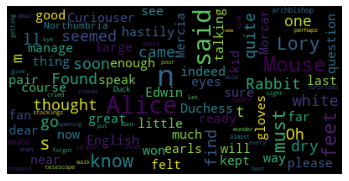

Document initial  ['“Curiouser and curiouser!” cried Alice (she was so much surprised, that for the moment she quite forgot how to speak good English); “now I’m opening out like the largest telescope that ever was! Good-bye, feet!” (for when she looked down at her feet, they seemed to be almost out of sight, they were getting so far off). “Oh, my poor little feet, I wonder who will put on your shoes and stockings for you now, dears? I’m sure I shan’t be able! I shall be a great deal too far off to trouble myself about you: you must manage the best way you can;—but I must be kind to them,” thought Alice, “or perhaps they won’t walk the way I want to go! Let me see: I’ll give them a new pair of boots every Christmas.”\nAnd she went on planning to herself how she would manage it. “They must go by the carrier,” she thought; “and how funny it’ll seem, sending presents to one’s own feet! And how odd the directions will look!\n     Alice’s Right Foot, Esq.,\n       Hearthrug,\n         near t

In [85]:
wc = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=35)
wc = wc.generate(str(testpratique))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.show()

print ("Document initial ", testpratique)
# suppression des caractères spéciaux
sentence = re.sub(r'[^\w\s]',' ', str(testpratique))
# suppression de tous les caractères uniques
sentence = re.sub(r'\s+[a-zA-Z]\s+', ' ', sentence)

# tokenisation
word_tokens = word_tokenize(sentence)
print ("Premiers tokens après nettoyage des données ", word_tokens)

# ne retenir que les categories NN et VB
# sauvegarde des mots dans un tableau selective_words. 
# selective_pos_words contient le mot et son tag
pos = nltk.pos_tag(word_tokens)
selective_pos = ['NN','VB']
selective_pos_words = []
selective_words=[]
for word,tag in pos:
     if tag in selective_pos:
         selective_pos_words.append((word,tag))
         selective_words.append(word)

print ("tokens conservés de catégorie NN ou VB")
print (selective_pos_words)
# racinisation


ps=nltk.stem.porter.PorterStemmer()


print("Racinisation")
print([ps.stem(word) for word in selective_words])

Nous savons maintenant nettoyer nos données et les transformer sous la forme de tokens. Aussi nous allons comment ces derniers peuvent être utilisés comme représentation des documents pour faire .... de la classification. La classification de données textuelles est présentée dans un autre notebook. 